In [1]:
import pickle
import matplotlib.pyplot as plt
import math
import numpy

import plotTools as pt

plt.rcParams.update({"text.usetex": True,"font.family": "serif"})

In [2]:
cosmoParamsPretty = {'omega_c_h2' : '$\Omega_ch^2$', \
                         'omega_b_h2' :    '$\Omega_bh^2$', \
                         'N_eff':   '$N_{eff}$', \
                         'A_s' :  '$A_s$', \
                         'n_s' : '$n_s$', \
                         'tau' :  r'$\tau$', \
                         'theta_s': r'$\theta_s$', \
                         'mnu' : r'$m_\nu$', \
                         'Yhe' : r'$Y_{He}$', \
                        'f_cdi': '$f_{cdi}$', \
                        'n_cdi': '$n_{cdi}$', \
                        'c_ad_cdi': '$c_{ad\;\;cdi}$', \
                        'r': '$r$', \
                        'H0': '$H_0$'}

In [3]:
jobNameLCDM = 'fisher_LCDM'

jobNamePlanck = 'fisher_Planck'

In [4]:
pythonFlag = 3
nExps = 20
sTypes = ["lensed","delensed","unlensed"]
gTypes = ["NonGaussian","Gaussian"]
noiseLevelsHi = numpy.arange(0.5, 10.5, 0.5)
fsky=0.5

fishersLCDM, cosmoParams1 = pt.loadGaussianNG(jobName = jobNameLCDM, pythonFlag = pythonFlag, \
                                  returnCosmoParams = True)

fishersPlanck, cosmoParamsPlanck = pt.loadGaussianNG(jobName = jobNamePlanck, pythonFlag = pythonFlag, \
                                                    returnCosmoParams = True)

paramsToFix = ['N_eff','mnu']
#paramsToFix = ['']

In [5]:
# fisher + fix + fsky + tau -> invert

for i in range(0,20):
    for gt, gaussianType in enumerate(gTypes):
        for st, spectrumType in enumerate(sTypes):
            
            fisher = fishersLCDM[gaussianType][spectrumType][i]
            fishersLCDM[gaussianType][spectrumType][i], fixedParamsLCDM = pt.fixParameters(fisher = fisher,\
                                                                               cosmoParams = cosmoParams1,\
                                                                               paramsToFix = paramsToFix,\
                                                                               returnFixedParamList = True)
            
for i in range(0,1):
    for gt, gaussianType in enumerate(gTypes):
        for st, spectrumType in enumerate(sTypes):           
            fisher = fishersPlanck[gaussianType][spectrumType][i]
            fishersPlanck[gaussianType][spectrumType][i], fixedParamsPlanck = pt.fixParameters(fisher = fisher, \
                                                                                                      cosmoParams = cosmoParamsPlanck, \
                                                                                                      paramsToFix = paramsToFix, \
                                                                                                      returnFixedParamList = True)

fishersSkyLCDM = pt.addfsky(fishersLCDM, fsky)
fishersSkyPlanck = pt.addfsky(fishersPlanck, 0.44)

fishersTauLCDM = pt.addTau(fishersSkyLCDM, fixedParamsLCDM)
fishersTauPlanck = pt.addTau(fishersSkyPlanck, fixedParamsPlanck)
    
sigmasLCDM = pt.invertFishers(fishersTauLCDM)
sigmasPlanck = pt.invertFishers(fishersTauPlanck)

FOMsLCDM = pt.getFOMs(sigmasLCDM)
FOMsPlanck = pt.getFOMs(sigmasPlanck)

In [6]:
FOMref = FOMsPlanck['NonGaussian']['lensed'][0]

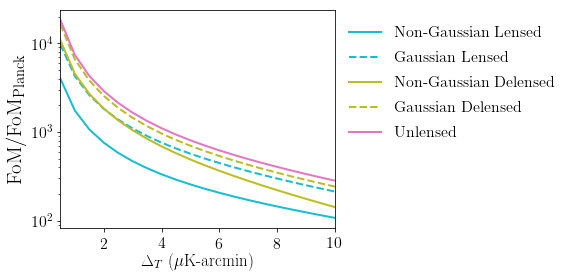

In [7]:
plt.figure('figure of merit',  figsize = (8,4))
plt.clf()

ax = plt.subplot()

toPlot1g = numpy.zeros(nExps)
toPlot1ng = numpy.zeros(nExps)

plt.margins(0.0,0.05)

for st, spectrumType in enumerate(sTypes):
    for gt, gaussianType in enumerate(gTypes):
        linestyles = ['--', '-', '-.']
        widths = [2, 2]
        colors = ['C9', 'C8', 'C6']

        for ei in range(0,nExps):
            toPlot1g[ei] = FOMsLCDM['Gaussian'][spectrumType][ei]/FOMref
            toPlot1ng[ei] = FOMsLCDM['NonGaussian'][spectrumType][ei]/FOMref
            if spectrumType == 'lensed':
                legendLabel = 'Lensed'
            elif spectrumType == 'delensed':
                legendLabel = 'Delensed'
            else:
                legendLabel = spectrumType

        if gaussianType == 'NonGaussian':
            if spectrumType == 'unlensed':
                plt.semilogy(noiseLevelsHi, toPlot1ng, color = colors[st], linestyle = linestyles[1], \
                         linewidth = widths[0], label = 'Unlensed')
            else:
                plt.semilogy(noiseLevelsHi, toPlot1ng, color = colors[st], linestyle = linestyles[1], \
                         linewidth = widths[0], label = 'Non-Gaussian '+legendLabel)
        if gaussianType == 'Gaussian':
            if spectrumType == 'lensed':
                plt.semilogy(noiseLevelsHi, toPlot1g, color = colors[st], linestyle = linestyles[0], \
                linewidth = widths[0], label = 'Gaussian Lensed')
            if spectrumType == 'delensed':
                plt.semilogy(noiseLevelsHi, toPlot1g, color = colors[st], linestyle = linestyles[0], \
                linewidth = widths[0], label = 'Gaussian Delensed')

plt.ylabel('$\mathrm{FoM}/\mathrm{FoM}_\mathrm{Planck}$', fontsize = 21)
plt.xlabel('$\Delta_T$ ($\mu$K-arcmin)', fontsize = 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor = (1., 1.), loc = 2, frameon = False, fontsize=16)
plt.tight_layout()
plt.savefig('fig_FoM.pdf')
plt.show()

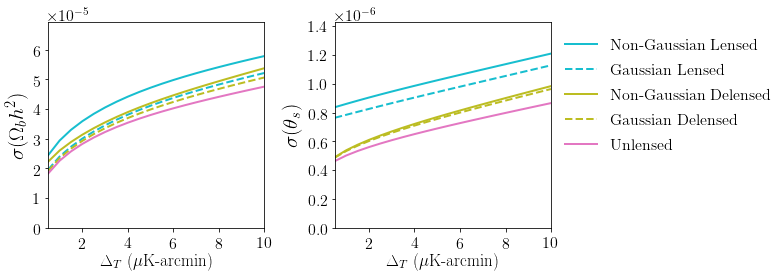

In [8]:
plt.figure('param constraints',  figsize = (11,4))
plt.clf()

toPlot1g = numpy.zeros(nExps)
toPlot1ng = numpy.zeros(nExps)

paramsToPlot = ['omega_b_h2','theta_s']

for cp, cosmo in enumerate(paramsToPlot):
    paramInd = fixedParamsLCDM.index(cosmo)

    ax = plt.subplot(1, 2, cp + 1)
    ax.margins(0.0,0.05)
    
    for st, spectrumType in enumerate(sTypes):
        for gt, gaussianType in enumerate(gTypes):
            linestyles = ['--', '-', '-.']
            widths = [2, 2]
            colors = ['C9', 'C8', 'C6']

            for ei in range(0,nExps):
                toPlot1g[ei] = math.sqrt(numpy.diag(sigmasLCDM['Gaussian'][spectrumType][ei])[paramInd])
                toPlot1ng[ei] = math.sqrt(numpy.diag(sigmasLCDM['NonGaussian'][spectrumType][ei])[paramInd])
                if spectrumType == 'lensed':
                    legendLabel = 'Lensed'
                elif spectrumType == 'delensed':
                    legendLabel = 'Delensed'
                else:
                    legendLabel = spectrumType
        
            if gaussianType == 'NonGaussian':
                if spectrumType == 'unlensed':
                    plt.plot(noiseLevelsHi, toPlot1ng, color = colors[st], linestyle = linestyles[1], \
                             linewidth = widths[0], label = 'Unlensed')
                else:
                    plt.plot(noiseLevelsHi, toPlot1ng, color = colors[st], linestyle = linestyles[1], \
                             linewidth = widths[0], label = 'Non-Gaussian '+legendLabel)
            if gaussianType == 'Gaussian':
                if spectrumType == 'lensed':
                    plt.plot(noiseLevelsHi, toPlot1g, color = colors[st], linestyle = linestyles[0], \
                    linewidth = widths[0], label = 'Gaussian Lensed')
                if spectrumType == 'delensed':
                    plt.plot(noiseLevelsHi, toPlot1g, color = colors[st], linestyle = linestyles[0], \
                    linewidth = widths[0], label = 'Gaussian Delensed')
            
        ymin, ymax = plt.ylim()
        plt.ylim(ymin=0.0, ymax = ymax*1.05)
    plt.ylabel('$\sigma($' + cosmoParamsPretty[cosmo] + '$)$', fontsize = 21)
    plt.xlabel('$\Delta_T$ ($\mu$K-arcmin)', fontsize = 17)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.yaxis.offsetText.set_fontsize(16)
plt.legend(bbox_to_anchor = (1., 1.), loc = 2, frameon = False, fontsize=16)
plt.tight_layout()
plt.savefig('fig-omegab-thetas.pdf')
plt.show()